## Import libraries needed

In [1]:
import pandas as pd
import numpy as np
import boto3
from pyathena import connect
import sagemaker
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [2]:
## set the session and roles for AWS
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Setup connection to Athena to pull in tables

In [3]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [4]:
# create the connection, this will be used anytime we need to query data from Athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [5]:
## Verify we have the database created
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)
## store teh db_name in a variable
db_name = str(db_show.iloc[0]['database_name'])

In [6]:
## we need to query the tables in and do a Join so it is one table to run our EDA off
db_name

'ads_508_team_5'

* Given the columns that are listed in each of these datasets, not all of the columns in any of the orders dataset is needed, once to look at in more detail are order_items: price, freight_value. order_payments: payment_type, payment_installments, payment_value. Order_reviews: review_score, orders_dataset: order_status

### Query in the data that we think is necessary for customer churn

In [7]:
churn_eda_query = """ SELECT
                        c.*,
                        ord.order_status,
                        ord.order_purchase_timestamp,
                        ordi.price,
                        ordi.freight_value,
                        ordp.payment_type,
                        ordp.payment_installments,
                        ordp.payment_value,
                        ordr.review_score
                    FROM
                    {db}.customers_table c
                    INNER JOIN {db}.orders_table ord ON ord.customer_id = c.customer_id 
                    INNER JOIN {db}.order_items_table ordi ON ordi.order_id = ord.order_id
                    INNER JOIN {db}.order_payments_table ordp ON ordp.order_id = ord.order_id
                    INNER JOIN {db}.order_reviews_table ordr ON ordr.order_id = ord.order_id""".format(db=db_name)

In [8]:
main_df =pd.read_sql(churn_eda_query, conn)
main_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,price,freight_value,payment_type,payment_installments,payment_value,review_score
0,"""06b8999e2fba1a1fbc88172c00ba8bc7""","""861eff4711a542e4b93843c6dd7febb0""",None,franca,SP,delivered,2017-05-16 15:05:35,124.99,21.88,credit_card,2,146.87,4
1,"""18955e83d337fd6b2def6b18a428ac77""","""290c77bc529b7ac935b93aa66c333dc3""",None,sao bernardo do campo,SP,delivered,2018-01-12 20:48:24,289.00,46.48,credit_card,8,335.48,5
2,"""4e7b3e00288586ebd08712fdd0374a03""","""060e732b5b29e8181a18229c7b0b2b5e""",None,sao paulo,SP,delivered,2018-05-19 16:07:45,139.94,17.79,credit_card,7,157.73,5
3,b2b6027bc5c5109e529d4dc6358b12c3,"""259dac757896d24d7702b9acbbff3f3c""",None,mogi das cruzes,SP,delivered,2018-03-13 16:06:38,149.94,23.36,credit_card,1,173.30,5
4,"""4f2d8ab171c80ec8364f7c12e35b23ad""","""345ecd01c38d18a9036ed96c73b8d066""",None,campinas,SP,delivered,2018-07-29 09:51:30,230.00,22.25,credit_card,8,252.25,5


In [9]:
main_df.dtypes

customer_id                         object
customer_unique_id                  object
customer_zip_code_prefix            object
customer_city                       object
customer_state                      object
order_status                        object
order_purchase_timestamp    datetime64[ns]
price                              float64
freight_value                      float64
payment_type                        object
payment_installments                 int64
payment_value                      float64
review_score                         int64
dtype: object

In [10]:
## In order for us to get teh customer churn we need to figure out who has made reorders and who has not, we can use the customer_id key 
## and teh customer unique key

# conver teh timestamp to a date time
main_df['order_purchase_timestamp'] = pd.to_datetime(main_df['order_purchase_timestamp'])
# get tehf irst and last purchase for each customer
purchase_dates = main_df.groupby('customer_unique_id').agg(first_purchase=pd.NamedAgg(column='order_purchase_timestamp', aggfunc='min'),
                                                       last_purchase=pd.NamedAgg(column='order_purchase_timestamp', aggfunc='max')).reset_index()
#Calculate the repurchase time in days for each customer
purchase_dates['repurchase_time'] = (purchase_dates['last_purchase'] - purchase_dates['first_purchase']).dt.days
churn_threshold = 180

# Identify churned customers based on the churn threshold
# Customers who have not made any repurchase within the churn threshold or who never made a repurchase
purchase_dates['churn'] = ((purchase_dates['repurchase_time'] > churn_threshold) | (purchase_dates['repurchase_time'] == 0)).astype(int)
df_with_churn = main_df.merge(purchase_dates[['customer_unique_id', 'churn']], on='customer_unique_id', how='inner')
df_with_churn['churn'].value_counts()

1    114069
0      4246
Name: churn, dtype: int64

### Churn Definition from above
* A value of 1 indicates that customer has churned because they haven't made a repruchase within 180 days of their first purchase
A churn value of 0 means that a customer has not churned, because they made a repurchase within 180 days after their first purchase

In [11]:
df_with_churn.describe()

,price,freight_value,payment_installments,payment_value,review_score,churn
count,118315.000000,118315.000000,118315.000000,118315.000000,118315.000000,118315.000000
mean,120.651027,20.033024,2.943498,172.575651,4.014554,0.964113
std,184.109626,15.836523,2.778022,267.104661,1.400186,0.186010
min,0.850000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,39.900000,13.080000,1.000000,60.850000,3.000000,1.000000
50%,74.900000,16.280000,2.000000,108.200000,5.000000,1.000000
75%,134.900000,21.180000,4.000000,189.260000,5.000000,1.000000
max,6735.000000,409.680000,24.000000,13664.080000,5.000000,1.000000


In [12]:
df_with_churn.isnull().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix    118315
customer_city                    0
customer_state                   0
order_status                     0
order_purchase_timestamp         0
price                            0
freight_value                    0
payment_type                     0
payment_installments             0
payment_value                    0
review_score                     0
churn                            0
dtype: int64

In [13]:
df_with_churn['order_status'].value_counts()

delivered      115728
shipped          1255
canceled          570
invoiced          376
processing        376
unavailable         7
approved            3
Name: order_status, dtype: int64

In [14]:
df_with_churn['customer_state'].value_counts()

SP    49865
RJ    15425
MG    13718
RS     6539
PR     5988
SC     4319
BA     4069
DF     2500
GO     2453
ES     2351
PE     1903
CE     1556
MT     1128
PA     1124
MS      856
MA      849
PB      640
PI      574
RN      571
AL      462
SE      397
TO      339
RO      286
AM      172
AC       95
AP       84
RR       52
Name: customer_state, dtype: int64

In [15]:
df_with_churn['payment_type'].value_counts()

credit_card    87266
boleto         23018
voucher         6332
debit_card      1699
Name: payment_type, dtype: int64

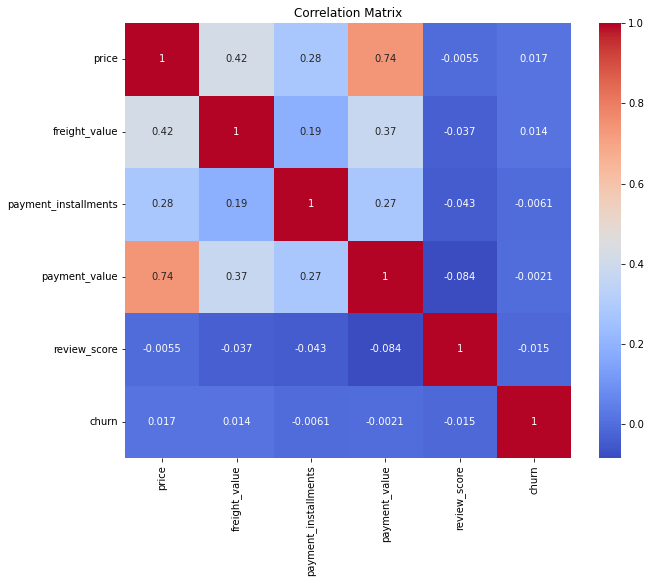

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_with_churn[["price", "freight_value", "payment_installments", "payment_value", "review_score", 'churn']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

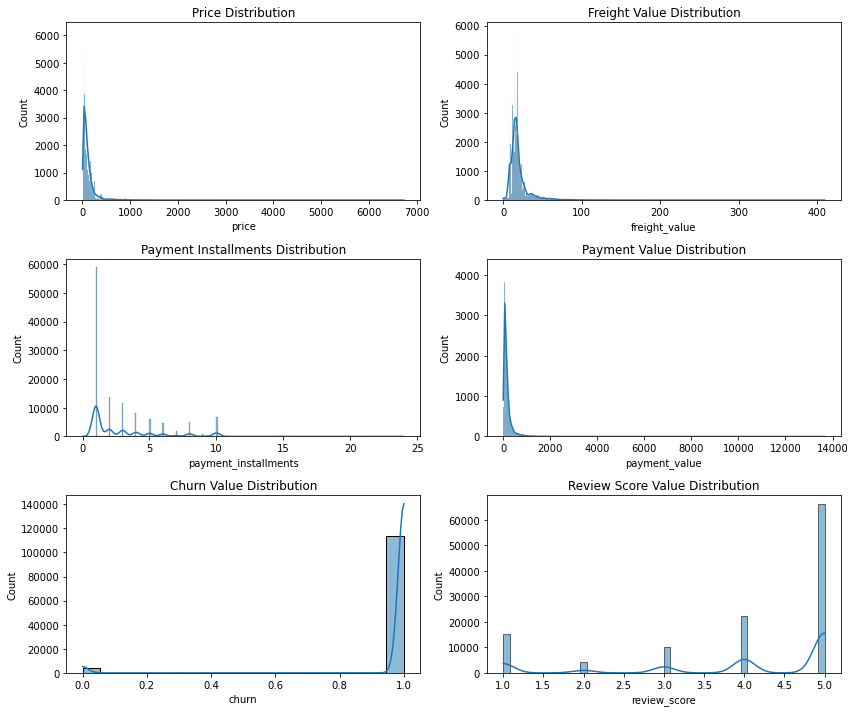

In [17]:
# Plotting distribution plots for numerical columns
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

sns.histplot(df_with_churn["price"], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Price Distribution")

sns.histplot(df_with_churn["freight_value"], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Freight Value Distribution")

sns.histplot(df_with_churn["payment_installments"], kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Payment Installments Distribution")

sns.histplot(df_with_churn["payment_value"], kde=True, ax=axs[1, 1])
axs[1, 1].set_title("Payment Value Distribution")

sns.histplot(df_with_churn["churn"], kde=True, ax=axs[2, 0])
axs[2, 0].set_title("Churn Value Distribution")

sns.histplot(df_with_churn["review_score"], kde=True, ax=axs[2, 1])
axs[2, 1].set_title("Review Score Value Distribution")

plt.tight_layout()
plt.show()

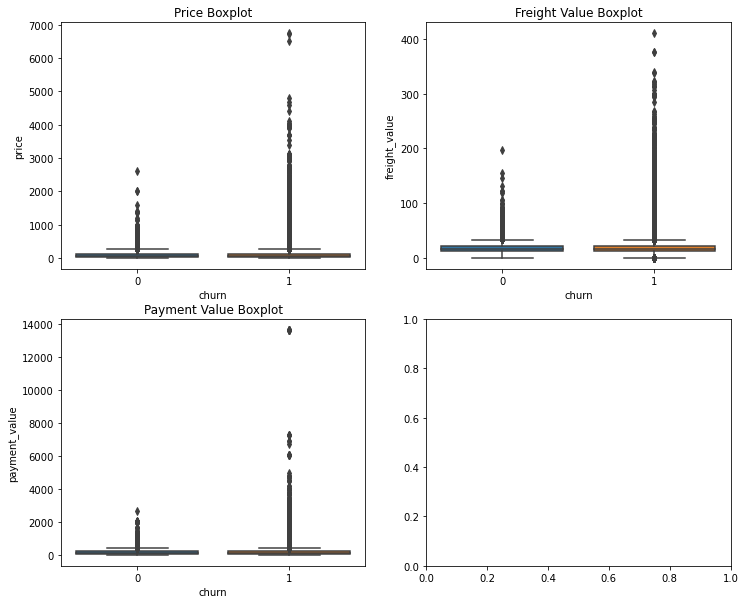

In [18]:
## create a boxplot for price freight_value payment_value by custmer churn
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x='churn', y='price', data=df_with_churn, ax=axs[0, 0])
axs[0, 0].set_title("Price Boxplot")
sns.boxplot(x='churn', y='freight_value', data=df_with_churn, ax=axs[0, 1])
axs[0, 1].set_title("Freight Value Boxplot")
sns.boxplot(x='churn', y='payment_value', data=df_with_churn, ax=axs[1, 0])
axs[1, 0].set_title("Payment Value Boxplot")
plt.show()


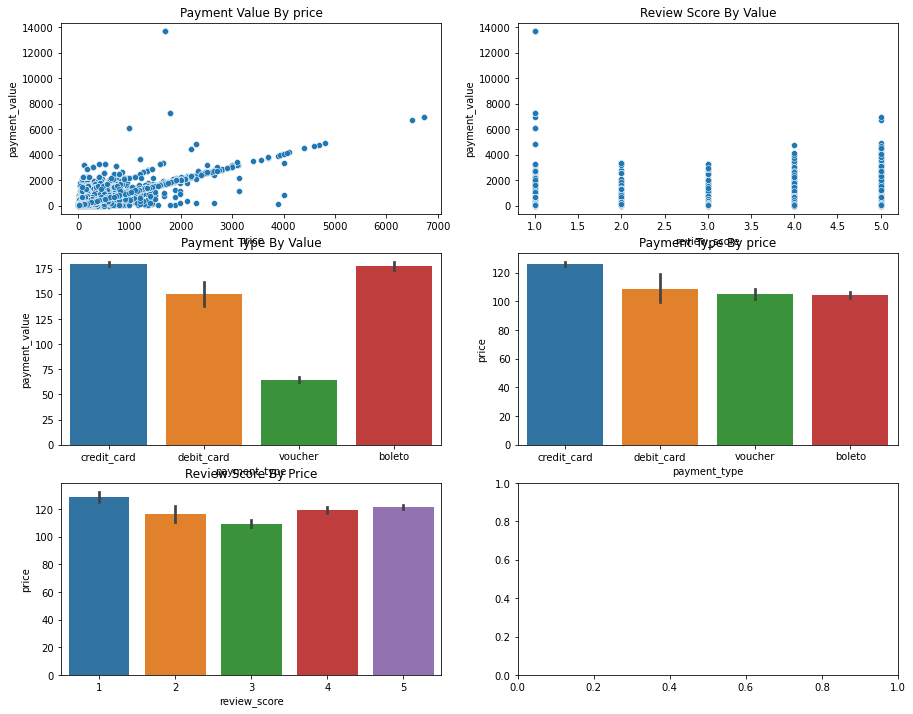

In [19]:
# create a scatter plot for the numeric features and churn
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
sns.scatterplot(y='payment_value', x='price', data=df_with_churn, ax=axs[0, 0])
axs[0, 0].set_title("Payment Value By price")
sns.scatterplot(x='review_score', y = 'payment_value', data=df_with_churn, ax=axs[0, 1])
axs[0, 1].set_title("Review Score By Value")
sns.barplot(x='payment_type', y = 'payment_value', data=df_with_churn, ax=axs[1, 0])
axs[1, 0].set_title("Payment Type By Value")
sns.barplot(x='payment_type', y = 'price', data=df_with_churn, ax=axs[1, 1])
axs[1, 1].set_title("Payment Type By price")
sns.barplot(x='review_score', y = 'price', data=df_with_churn, ax=axs[2, 0])
axs[2, 0].set_title("Review Score By Price")
plt.show();


In [20]:
df_with_churn['customer_city'].value_counts()

sao paulo             18728
rio de janeiro         8261
belo horizonte         3274
brasilia               2484
curitiba               1816
                      ...  
sao jose do piaui         1
jardim de piranhas        1
ciriaco                   1
aratiba                   1
eugenio de castro         1
Name: customer_city, Length: 4110, dtype: int64

## Pre-process the data

In [21]:
df_with_churn.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_status,order_purchase_timestamp,price,freight_value,payment_type,payment_installments,payment_value,review_score,churn
0,"""06b8999e2fba1a1fbc88172c00ba8bc7""","""861eff4711a542e4b93843c6dd7febb0""",None,franca,SP,delivered,2017-05-16 15:05:35,124.99,21.88,credit_card,2,146.87,4,1
1,"""18955e83d337fd6b2def6b18a428ac77""","""290c77bc529b7ac935b93aa66c333dc3""",None,sao bernardo do campo,SP,delivered,2018-01-12 20:48:24,289.00,46.48,credit_card,8,335.48,5,1
2,"""4e7b3e00288586ebd08712fdd0374a03""","""060e732b5b29e8181a18229c7b0b2b5e""",None,sao paulo,SP,delivered,2018-05-19 16:07:45,139.94,17.79,credit_card,7,157.73,5,1
3,b2b6027bc5c5109e529d4dc6358b12c3,"""259dac757896d24d7702b9acbbff3f3c""",None,mogi das cruzes,SP,delivered,2018-03-13 16:06:38,149.94,23.36,credit_card,1,173.30,5,1
4,"""4f2d8ab171c80ec8364f7c12e35b23ad""","""345ecd01c38d18a9036ed96c73b8d066""",None,campinas,SP,delivered,2018-07-29 09:51:30,230.00,22.25,credit_card,8,252.25,5,1


In [22]:
# columns to drop: Ids, Zip, State. These are two unique columns to add to the model. Also drop Timestamp
# new dataframe
new_df = df_with_churn.drop(columns = ['customer_id', 
                                      'customer_unique_id', 
                                      'customer_zip_code_prefix', 
                                      'customer_city',
                                      'customer_state',
                                      'order_purchase_timestamp',
                                     ]
                           )
new_df.head()

,order_status,price,freight_value,payment_type,payment_installments,payment_value,review_score,churn
0,delivered,124.99,21.88,credit_card,2,146.87,4,1
1,delivered,289.00,46.48,credit_card,8,335.48,5,1
2,delivered,139.94,17.79,credit_card,7,157.73,5,1
3,delivered,149.94,23.36,credit_card,1,173.30,5,1
4,delivered,230.00,22.25,credit_card,8,252.25,5,1


In [23]:
new_df.dtypes

order_status             object
price                   float64
freight_value           float64
payment_type             object
payment_installments      int64
payment_value           float64
review_score              int64
churn                     int64
dtype: object

In [24]:
def check_category_dtypes(dataset):
    category_columns = []
    for i in dataset:
        if dataset[i].dtype == 'object':
            category_columns.append(i)
        elif dataset[i].dtype == 'category':
            category_columns.append(i)
    return category_columns

In [25]:
from numpy.lib.shape_base import column_stack
# apply OHE to the label_text column
def apply_ohe(dataset):
    # Assuming check_category_dtypes(dataset) correctly returns a list of categorical column names
    category_columns = check_category_dtypes(dataset)
    
    # Initialize OneHotEncoder
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # Fit and transform the categorical columns
    ohe_data = ohe.fit_transform(dataset[category_columns])
    
    # Create a DataFrame with the encoded data and column names derived from the encoder
    new_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(category_columns), index=dataset.index)
    
    # Concatenate the original dataset (minus the categorical columns) with the new encoded DataFrame
    final_df = pd.concat([dataset.drop(columns=category_columns), new_df], axis=1)
    
    return final_df

In [26]:
## apply one hot encoding to the dataset
encoded_df = apply_ohe(new_df)
encoded_df

/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,price,freight_value,payment_installments,payment_value,review_score,churn,order_status_approved,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,124.99,21.88,2,146.87,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,289.00,46.48,8,335.48,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,139.94,17.79,7,157.73,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,149.94,23.36,1,173.30,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,230.00,22.25,8,252.25,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,74.90,13.88,6,88.78,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118311,114.90,14.16,3,129.06,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118312,37.00,19.04,5,56.04,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118313,689.00,22.07,2,711.07,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
## split the data into taining and testing sets
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
X = encoded_df.drop(columns = 'churn')
y = encoded_df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)
## balance the data
# Initialize SMOTE
smote = SMOTE(random_state=42)
smoteen = SMOTEENN(random_state=42)
# Fit and resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smoteen, y_train_smoteen = smoteen.fit_resample(X_train, y_train)

In [28]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming Xt and y_train_smote are already defined
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_train_smote['churn'])

# If y_train_smote is a Series or an array, just use it directly. If it's a DataFrame, access the relevant column.
labels = y_train_smote.unique() if not isinstance(y_train_smote, pd.DataFrame) else y_train_smote['churn'].unique()

# Create custom handles
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10),
           Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10)]

# Add legend to plot
plt.legend(handles, labels)
plt.show()

NameError: name 'Xt' is not defined

In [29]:
## Scale the data
scaler = StandardScaler()
scaler.fit(X_train_smote)
X_train_scaled = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


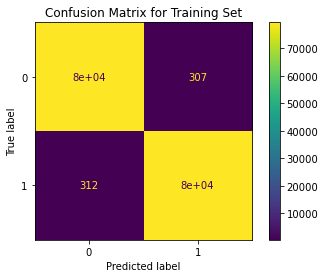

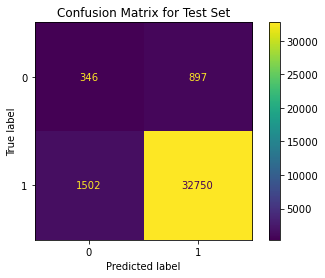

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79817
           1       1.00      1.00      1.00     79817

    accuracy                           1.00    159634
   macro avg       1.00      1.00      1.00    159634
weighted avg       1.00      1.00      1.00    159634


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.19      0.28      0.22      1243
           1       0.97      0.96      0.96     34252

    accuracy                           0.93     35495
   macro avg       0.58      0.62      0.59     35495
weighted avg       0.95      0.93      0.94     35495



In [30]:
## build a RF model to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_smote)
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)
cm_train = confusion_matrix(y_train_smote, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix plots
labels = rf.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

# Plot confusion matrix for training set
cmplot_train.plot()
plt.title('Confusion Matrix for Training Set')
plt.show()

# Plot confusion matrix for test set
cmplot_test.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

# Build classification reports
rf_train_report = classification_report(y_train_smote, y_pred_train)
rf_test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set:")
print(rf_train_report)
print("\nClassification Report for Test Set:")
print(rf_test_report)


In [31]:
scaler = StandardScaler()
scaler.fit(X_train_smoteen)
X_train_scaled = scaler.transform(X_train_smoteen)
X_test_scaled = scaler.transform(X_test)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


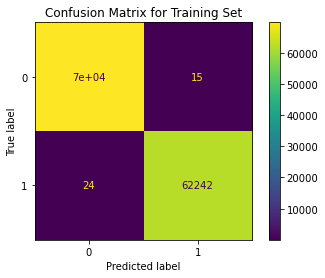

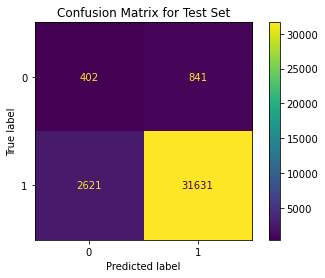

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69778
           1       1.00      1.00      1.00     62266

    accuracy                           1.00    132044
   macro avg       1.00      1.00      1.00    132044
weighted avg       1.00      1.00      1.00    132044


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.13      0.32      0.19      1243
           1       0.97      0.92      0.95     34252

    accuracy                           0.90     35495
   macro avg       0.55      0.62      0.57     35495
weighted avg       0.94      0.90      0.92     35495



In [33]:
## build a RF model to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_smoteen)
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)
cm_train = confusion_matrix(y_train_smoteen, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Create confusion matrix plots
labels = rf.classes_
cmplot_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
cmplot_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)

# Plot confusion matrix for training set
cmplot_train.plot()
plt.title('Confusion Matrix for Training Set')
plt.show()

# Plot confusion matrix for test set
cmplot_test.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

# Build classification reports
rf_train_report = classification_report(y_train_smoteen, y_pred_train)
rf_test_report = classification_report(y_test, y_pred_test)

print("Classification Report for Training Set:")
print(rf_train_report)
print("\nClassification Report for Test Set:")
print(rf_test_report)


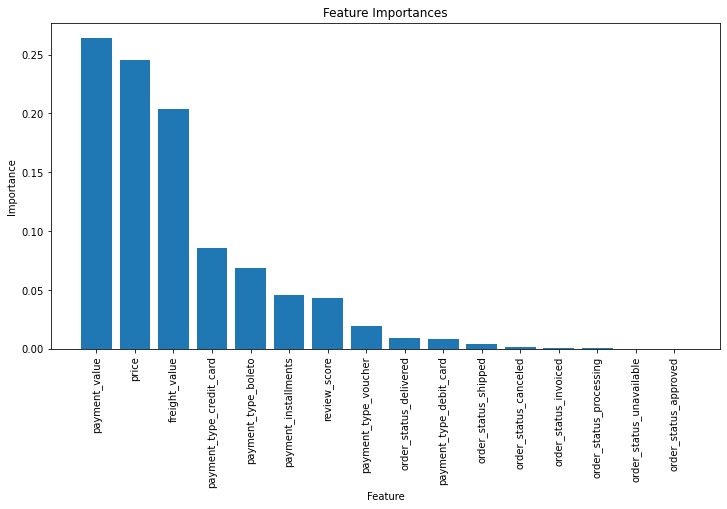

In [34]:
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame to find out the most important features
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}